In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from train_set import Training_set
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import  classification_report
from numpy import mean, std

# Import the dataset of biological selected features

In [75]:
bio_features = pd.read_csv("bio_data.csv", index_col= 0)
X = bio_features
#Y has the last col with labels
y = Training_set.iloc[:, -1]
# split the dataset to train and test, the 2nd is for the non feature selection
Training_data = pd.merge(X, y, left_index=True, right_index=True)


X = Training_data.iloc[:, :-1]
#Y has the last col with labels
y = Training_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# NESTED CV to evaluate performance and get some good sets of hyperparameters

In [ ]:
# Split the generated data into training and testing sets
skf_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
actual_scores = []

# Define the parameter grid for the random forest classifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
for train_index_inner, test_index_inner in skf_outer.split(X_train, y_train):
    X_train_inner, X_test_inner = X_train.iloc[train_index_inner], X_train.iloc[test_index_inner]
    y_train_inner, y_test_inner = y_train.iloc[train_index_inner], y_train.iloc[test_index_inner]

    # parameter tuning for the random forest classifier using GridSearchCV
    rf_model = RandomForestClassifier(random_state=42)

    # Inner cross-validation loop for hyperparameter tuning
    skf_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid, scoring='accuracy', cv=skf_inner)

    grid_search.fit(X_train_inner, y_train_inner)
    best_model = grid_search.best_estimator_
    yhat = best_model.predict(X_test_inner)
    acc= accuracy_score(y_test_inner,yhat)
    actual_scores.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, grid_search.best_score_, grid_search.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(actual_scores), std(actual_scores)))

# Pick each set output of the previous grid search and evaluate each one in a nested cross-validation to see performance, and pick the one with mean highest accuracy as set for our final model.

In [49]:
# Split the generated data into training and testing sets
skf_outer2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
actual_scores2 = []


for train_index_inner, test_index_inner in skf_outer2.split(X_train, y_train):
    X_train_inner, X_test_inner = X_train.iloc[train_index_inner], X_train.iloc[test_index_inner]
    y_train_inner, y_test_inner = y_train.iloc[train_index_inner], y_train.iloc[test_index_inner]



    # Inner cross-validation loop for hyperparameter tuning
    rf_model2 = RandomForestClassifier(max_depth=5, min_samples_leaf=1,min_samples_split=10,n_estimators=100,
                                       random_state=42)

    rf = rf_model2.fit(X_train_inner, y_train_inner)

    yhat2 = rf.predict(X_test_inner)
    acc2= accuracy_score(y_test_inner,yhat2)
    actual_scores2.append(acc2)
    # report progress
    print('>acc=%.3f' % (acc2))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(actual_scores2), std(actual_scores2)))

>acc=0.875
>acc=0.875
>acc=0.812
>acc=0.938
>acc=1.000
Accuracy: 0.900 (0.064)


# Final model to test also here the best hyper parameters in the test set


In [76]:
clf_final = RandomForestClassifier( max_depth=5, min_samples_leaf=1,min_samples_split=10,n_estimators=100,
                                   random_state=42)

clf_final.fit(X_train, y_train)
# Evaluate the trained classifier on the test set
y_pred_final = clf_final.predict(X_test)
score_total = accuracy_score(y_test, y_pred_final)
precision = metrics.precision_score(y_test, y_pred_final, average='macro')
recall = metrics.recall_score(y_test, y_pred_final, average='macro')
f1_score = metrics.f1_score(y_test, y_pred_final, average='macro')

print(" Accuracy: {:.2f}%".format(score_total * 100))
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1_score:.3f}')

 Accuracy: 90.00%
Precision: 0.926
Recall: 0.889
F1-score: 0.892


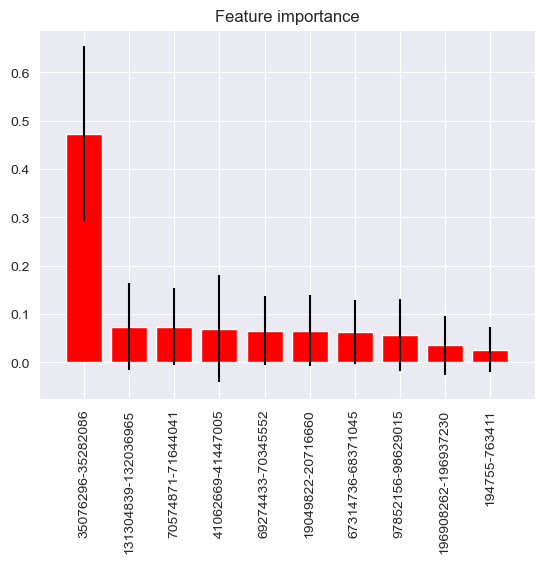

In [54]:
importances = clf_final.feature_importances_
n = 11
indices = importances.argsort()[::-1][:n]
# Visualize the feature importance
std = np.std([tree.feature_importances_ for tree in clf_final.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importance")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [51]:
cr = classification_report(y_test, y_pred_final)
print(cr)

              precision    recall  f1-score   support

       HER2+       1.00      1.00      1.00         7
         HR+       0.78      1.00      0.88         7
  Triple Neg       1.00      0.67      0.80         6

    accuracy                           0.90        20
   macro avg       0.93      0.89      0.89        20
weighted avg       0.92      0.90      0.90        20



In [77]:
import joblib
joblib.dump(clf_final, filename = 'rf_bio.pkl')

['rf_bio.pkl']

In [79]:
t = pd.read_csv('pckl_models\\Validation_set.csv')

In [80]:
print(t)
print

   Unnamed: 0  196908262-196937230  69274433-70345552  19049822-20716660  \
0     Array.1                    0                  1                  0   
1    Array.61                   -1                  0                  0   
2    Array.70                    0                  0                  1   
3    Array.14                    0                  1                  0   
4    Array.91                    0                  0                  0   
5    Array.58                    0                  0                  0   
6   Array.140                    1                  0                 -1   
7    Array.20                    0                  0                  0   
8   Array.133                    1                  0                  1   
9    Array.77                    0                  0                  0   
10  Array.131                   -1                  0                  0   
11   Array.84                   -1                  0                  1   
12   Array.4

In [84]:
p = pd.read_csv('testarw.csv')
df = p.drop(p.filter(like='Unnamed').columns, axis=1)
print(df)

    69274433-70345552  196908262-196937230  19049822-20716660  \
0                  -1                    0                  1   
1                  -1                    1                  0   
2                  -1                   -1                  0   
3                   0                    1                  0   
4                   0                    0                  0   
..                ...                  ...                ...   
75                 -1                    0                  0   
76                  0                    0                  0   
77                  0                    0                  1   
78                  0                    1                  1   
79                  0                    0                  0   

    131304839-132036965  70574871-71644041  97852156-98629015  \
0                    -1                 -1                 -1   
1                     0                  0                  0   
2                     0 

In [83]:
print(X_train)

           69274433-70345552  196908262-196937230  19049822-20716660  \
Array.88                  -1                    0                  1   
Array.47                  -1                    1                  0   
Array.110                 -1                   -1                  0   
Array.56                   0                    1                  0   
Array.82                   0                    0                  0   
...                      ...                  ...                ...   
Array.68                  -1                    0                  0   
Array.139                  0                    0                  0   
Array.118                  0                    0                  1   
Array.30                   0                    1                  1   
Array.141                  0                    0                  0   

           131304839-132036965  70574871-71644041  97852156-98629015  \
Array.88                    -1                 -1              